 

#### Overall Introduction
In this notebook, we will be using `pytorch` and hugging face `transformers` to work with large language models (LLMs). More specifically, we will use encoder models to reterieve sentence embeddings for the `IMDB` dataset. Then, these embeddings will be used as input features for the downstream machine learning task where we will build a logistic regression classifier with L1 regularization.

In [1]:
import torch
import os
import numpy as np
from datasets import load_from_disk
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel 
from warnings import filterwarnings
from torch.utils.data import DataLoader

filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"


/software/python-anaconda-2022.05-el8-x86_64/envs/transformers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Mon Jan 20 10:45:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:B1:00.0 Off |                    0 |
| N/A   38C    P0              52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Data

This code snippet below demonstrates a simple workflow for loading and inspecting the IMDB dataset using the Hugging Face Datasets library.

- **Data Path Definition:**  
  The variable `data_path` is set to the location where the dataset is stored. In this case, it points to the IMDB dataset (sourced from [Stanford NLP's IMDB dataset on Hugging Face](https://huggingface.co/datasets/stanfordnlp/imdb)).

- **Loading the Dataset:**  
  The `load_from_disk(data_path)` function loads the dataset from the specified path into memory.

- **Inspecting the Dataset:**  
  - `print(dataset["train"][0])` outputs the first training sample, which is useful for understanding the structure and content of a single example.
  - `print(dataset)` displays the overall structure of the dataset, including its splits and metadata.

This introductory code is ideal for verifying that the dataset has been loaded correctly and for exploring its initial structure before proceeding with further analysis or processing.


In [3]:
data_path = "/project/rcc/shared/ai-workshops/imdb" # source https://huggingface.co/datasets/stanfordnlp/imdb

# Load the dataset
dataset = load_from_disk(data_path)
print(dataset["train"][0])
print(dataset)

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

### Embedding Model

The code sets up a pre-trained model for inference using the Hugging Face Transformers library:

- **Model Path Specification:**  
  - The variable `model_name` points to the local directory where the `bge-large-en-v1.5` model (from BAAI) is stored.  
  - Source: [BAAI/bge-large-en-v1.5 on Hugging Face](https://huggingface.co/BAAI/bge-large-en-v1.5).

- **Loading Tokenizer and Model:**  
  - `AutoTokenizer.from_pretrained(model_name)` loads the tokenizer, which handles converting text to tokens based on the model’s vocabulary.  
  - `AutoModel.from_pretrained(model_name)` loads the corresponding model.

- **Device Setup for Inference:**  
  - The code checks if a CUDA-enabled GPU is available using `torch.cuda.is_available()` and sets the device accordingly.  
  - `model.to(device)` moves the model to the selected device (GPU if available, otherwise CPU) for efficient computation.

This setup is essential for performing inference or further fine-tuning with the specified model.


In [2]:
# Load the pre-trained model and tokenizer
model_name = "/project/rcc/shared/ai-workshops/bge-large-en-v1.5" # source https://huggingface.co/BAAI/bge-large-en-v1.5

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

print(tokenizer)


BertTokenizerFast(name_or_path='/project/rcc/shared/ai-workshops/bge-large-en-v1.5', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [3]:
# calculate the model parameters
params = sum(p.numel() for p in model.parameters())
print(f"The LLM has {params} parameters") # Question: how much memory does this model require? 

The LLM has 335141888 parameters


In [4]:
# move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

### Text preprocessing for embedding

- **Set Batch Size:**  
  Batch size is set to 256. Depending on the GPU HBM. 

- **Tokenization:**  
  The train and test texts are tokenized with truncation and padding to a maximum of 512 tokens, outputting PyTorch tensors.

- **DataLoader Creation:**  
  TensorDatasets (combining input IDs and attention masks) are wrapped in DataLoaders for both train and test sets, using the defined batch size and 6 worker threads (used 6 CPU cores).


In [5]:
# Define batch size
BATCH_SIZE = 256

# Tokenize train and test datasets with batching
train_encodings = tokenizer(
    dataset["train"]["text"],
    truncation=True,
    max_length=512,
    padding=True,  # Add padding to ensure all sequences in a batch have the same length
    return_tensors="pt"
)

test_encodings = tokenizer(
    dataset["test"]["text"],
    truncation=True,
    max_length=512,
    padding=True,
    return_tensors="pt"
)

# Create DataLoader for batching
train_data = DataLoader(
    torch.utils.data.TensorDataset(
        train_encodings["input_ids"], train_encodings["attention_mask"]
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=6  # adjust to the number of CPU cores available
)

test_data = DataLoader(
    torch.utils.data.TensorDataset(
        test_encodings["input_ids"], test_encodings["attention_mask"]
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=6 # adjust to the number of CPU cores available
)


### Processing training embeddings

- **Evaluation Mode & No Gradients:**  
  The model is set to evaluation mode (`model.eval()`) and wrapped in a `torch.no_grad()` context to disable training-specific behaviors.

- **Last Hidden State Extraction:**  
  For each batch from `train_data`, the model computes the last hidden states. The code then pools the embeddings by selecting the first token (the CLS token) from each sequence, which represents a summary of the input.

- **Aggregation:**  
  The CLS embeddings are converted to NumPy arrays and aggregated for downstream processing.



In [6]:
# Extract CLS embeddings for training encodings in batches
train_cls_embeddings = []

print("Extracting CLS embeddings for train data...")
model.eval()  # Set model to evaluation mode
for batch in tqdm(train_data):
    input_ids, attention_mask = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state

        # Extract CLS token (first token) embeddings from each sequence in the batch
        cls_embeddings = last_hidden_states[:, 0, :]  # Shape: (batch_size, hidden_size)
        train_cls_embeddings.extend(cls_embeddings.cpu().numpy())

# (Optional) Convert train_cls_embeddings to NumPy array for easier downstream processing
train_cls_embeddings = np.array(train_cls_embeddings)

print(f"Extracted {len(train_cls_embeddings)} CLS embeddings for train data.")
print(f"The shape of the extracted embeddings is: {train_cls_embeddings.shape}")

Extracting CLS embeddings for train data...


  0%|                                         | 0/98 [00:00<?, ?it/s]

100%|████████████████████████████████| 98/98 [07:37<00:00,  4.67s/it]

Extracted 25000 CLS embeddings for train data.
The shape of the extracted embeddings is: (25000, 1024)


### Computing test embeddings

In [7]:
# Repeat the same process for test data
test_cls_embeddings = []

print("Extracting CLS embeddings for test data...")
for batch in tqdm(test_data):
    input_ids, attention_mask = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state

        # Extract CLS token embeddings
        cls_embeddings = last_hidden_states[:, 0, :]
        test_cls_embeddings.extend(cls_embeddings.cpu().numpy())

test_cls_embeddings = np.array(test_cls_embeddings)

print(f"Extracted {len(test_cls_embeddings)} CLS embeddings for test data.")
print(f"The shape of the extracted embeddings is: {train_cls_embeddings.shape}")


Extracting CLS embeddings for test data...


100%|███████████| 98/98 [07:37<00:00,  4.66s/it]

Extracted 25000 CLS embeddings for test data.
The shape of the extracted embeddings is: (25000, 1024)


### Saving embeddings (optional)

In [8]:
# save train_cls_embeddings into pickle file
import pickle
with open("/project/rcc/shared/ai-workshops/train_cls_embeddings.pkl", "wb") as f:
    pickle.dump(train_cls_embeddings, f)


# save test_cls_embeddings into pickle file
with open("/project/rcc/shared/ai-workshops/test_cls_embeddings.pkl", "wb") as f:
    pickle.dump(test_cls_embeddings, f)


#### Glancing the embeddings

In [1]:
import pandas as pd

# Load the train cls embeddings
train_cls_embeddings = pd.read_pickle("/project/rcc/shared/ai-workshops/train_cls_embeddings.pkl")

# print the dimensions
print(train_cls_embeddings.shape)

# print the first example
print(train_cls_embeddings[0])

(25000, 1024)
[ 0.44738615 -0.21731704 -0.28032333 ...  0.4200335   0.18223956
  0.29111037]


### Downstram ML classification tasks

#### I. Principal Component Analysis (PCA)

**PCA** is a linear dimensionality reduction technique that projects high-dimensional data onto a lower-dimensional space while preserving as much variance as possible. It works by:

- **Identifying the Principal Components:**  
  Finding new, orthogonal axes (directions) that capture the maximum variance in the data.
- **Reducing Dimensionality:**  
  Projecting the original data onto these components (typically the first two for visualization) to simplify analysis and visualization.



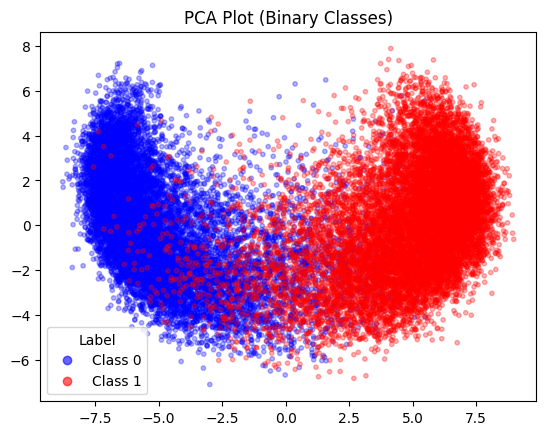

In [9]:
# Use PCA to reduce the dimensionality of the embeddings and make a scatter plot with labels
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Fit PCA to the embeddings
pca = PCA(n_components=2)
train_cls_embeddings_pca = pca.fit_transform(train_cls_embeddings)

# PCA embeddings and labels
embeddings = train_cls_embeddings_pca
labels = np.array(dataset["train"]["label"])

# Automatically get unique class names from labels
unique_labels = np.unique(labels)
class_names = [f"Class {int(label)}" for label in unique_labels]

# Create a discrete colormap for the number of unique labels
cmap = mcolors.ListedColormap(["blue", "red"][:len(unique_labels)])  # Adjust if >2 classes

# plt.figure(figsize=(10, 10))

# Single scatter with color coded by label
sc = plt.scatter(
    embeddings[:, 0], embeddings[:, 1],
    c=labels,
    cmap=cmap,
    alpha=0.3,
    s = 10
)

# Automatically create legend handles/labels
handles, _ = sc.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, class_names, title="Label")
plt.title("PCA Plot (Binary Classes)")
plt.show()

#### Plot summary
This PCA visualization of the LLM embeddings shows a clear separation between the two classes in only two dimensions. Even though the embeddings live in a 1024-dimensional space, projecting them down to 2D with PCA still preserves enough structure to cluster the blue (Class 0) points largely on the left and the red (Class 1) points on the right. The relative lack of overlap between the classes in this compressed space suggests that the LLM-generated embeddings are capturing meaningful differences between the two classes, allowing for a strong separation even when significantly reduced in dimensionality.

#### II. Logistic Regression with L1 regularization

In [10]:
# fetch the labels from the dataset
train_labels = np.array(dataset["train"]["label"])
test_labels = np.array(dataset["test"]["label"])

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid
param_grid = {
    "clf__C": [0.01, 0.02, 0.03, 0.033, 0.034, 0.035, 0.036, 0.04, 0.045, 1.0],  # Regularization strength, 1/lambda
    "clf__penalty": ["l1"],               # L1 regularization
    "clf__solver": ["liblinear"],         # Solver for L1 regularization
}

# Define the logistic regression model
model = LogisticRegression(
    max_iter=1000,
    random_state=42
)


# Create a pipeline that first scales the data and then applies LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Note: Always make sure to standardize the data within the cross-validation loop to avoid data leakage
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="accuracy",  # Use accuracy as the evaluation metric
    cv=10,               # 10-fold cross-validation
    n_jobs=-1           # Use all available CPU cores
)

# Fit the grid search on the training data
grid_search.fit(train_cls_embeddings, train_labels)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}") # make sure the best parameters are roughtly at the center of the grid
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Train the best model on the full training set
best_model = grid_search.best_estimator_
best_pipeline = grid_search.best_estimator_


# Evaluate on the test set
test_predictions = best_pipeline.predict(test_cls_embeddings)

# test_predictions = best_model.predict(test_embeddings_scaled)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report(test_labels, test_predictions))


Best Parameters: {'clf__C': 0.036, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.9418
Test Accuracy: 0.9450
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     12500
           1       0.94      0.95      0.95     12500

    accuracy                           0.95     25000
   macro avg       0.95      0.95      0.95     25000
weighted avg       0.95      0.95      0.95     25000



#### Summary

In this notebook, we have done the following:

- Implemented a flexible framework/pipeline, processing and analyzing text
- Leveraged an encoder LLM to compute embeddings for IMDB reviews
- Applied unsupervsed learning (PCA) 
- Built a classifer for sentiment analysis (L1 regularzation is always encouraged thanks to the curse of dimensionality)

N.B. class imbalance issue should be dealt with speciality, although we don't have it here. 

#### Future work

- Error analysis (i.e., manually checking the falsely classified data points in the test data)
- Switch to an LLM with larger context size, or apply a context window for existing
- Use non-linear dimension reduction techniques (e.g., t-sne, UMAP)
- Train a different classifier (e.g., SVM, Random Forest, XGBoost, etc.)
- Adopt the framework into your own work 
- Build a faiss vector database for QA